In [21]:
!pip install pandas numpy scikit-learn matplotlib seaborn pandasql

In [22]:
import pandas as pd
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [23]:
print(df.head())
print(df.shape)

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [24]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [25]:
print(df.describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [26]:
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [27]:
from pandasql import sqldf

In [28]:
pysqldf = lambda q: sqldf(q, globals())

In [29]:
query1 = "SELECT Contract, COUNT(*) as Count FROM df GROUP BY Contract;"
print(pysqldf(query1))

         Contract  Count
0  Month-to-month   3875
1        One year   1473
2        Two year   1695


In [30]:
query2 = "SELECT Churn, AVG(MonthlyCharges) as AvgCharges FROM df GROUP BY Churn;"
print(pysqldf(query2))

  Churn  AvgCharges
0    No   61.265124
1   Yes   74.441332


In [31]:
query3 = "SELECT PaymentMethod, SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as ChurnCount FROM df GROUP BY PaymentMethod;"
print(pysqldf(query3))

               PaymentMethod  ChurnCount
0  Bank transfer (automatic)         258
1    Credit card (automatic)         232
2           Electronic check        1071
3               Mailed check         308


In [32]:
df.drop('customerID', axis=1, inplace=True)

In [35]:
#Convert TotalCharges to numeric, fill missing with median
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  #Spaces to NaN
print(df['TotalCharges'].isnull().sum())  #=11
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True) #Used median to avoid skew in TotalCharges
print(df['TotalCharges'].isnull().sum())

0
0


/tmp/ipython-input-2532693599.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [37]:
#Convert binary columns (Yes/No) to 1/0 for modeling
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})  #Target
print(df[binary_cols + ['Churn']].head())  #Verify 1s and 0s

   Partner  Dependents  PhoneService  MultipleLines  OnlineSecurity  \
0        1           0             0              0               0   
1        0           0             1              0               1   
2        0           0             1              0               1   
3        0           0             0              0               1   
4        0           0             1              0               0   

   OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
0             1                 0            0            0                0   
1             0                 1            0            0                0   
2             1                 0            0            0                0   
3             0                 1            1            0                0   
4             0                 0            0            0                0   

   PaperlessBilling  Churn  
0                 1      0  
1                 0      0  
2    

In [38]:
#My check: confirm no text remains in binary columns
print(df[binary_cols].dtypes)  #Should be int64

Partner             int64
Dependents          int64
PhoneService        int64
MultipleLines       int64
OnlineSecurity      int64
OnlineBackup        int64
DeviceProtection    int64
TechSupport         int64
StreamingTV         int64
StreamingMovies     int64
PaperlessBilling    int64
dtype: object


In [39]:
#One-hot encode categorical columns (e.g., gender, Contract)
df = pd.get_dummies(df, columns=['gender', 'InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
print(df.shape)  #Expected is (7043, 20-30)
print(df.head())  #See new columns like Contract_One year

(7043, 24)
   SeniorCitizen  Partner  Dependents  tenure  PhoneService  MultipleLines  \
0              0        1           0       1             0              0   
1              0        0           0      34             1              0   
2              0        0           0       2             1              0   
3              0        0           0      45             0              0   
4              0        0           0       2             1              0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  ...  \
0               0             1                 0            0  ...   
1               1             0                 1            0  ...   
2               1             1                 0            0  ...   
3               1             0                 1            1  ...   
4               0             0                 0            0  ...   

   TotalCharges  Churn  gender_Male  InternetService_Fiber optic  \
0         29.85      0   

In [40]:
#Create custom feature: CostPerMonth (charges per month of tenure)
df['CostPerMonth'] = df['MonthlyCharges'] / (df['tenure'] + 1)  #To avoid division by zero
print(df['CostPerMonth'].head())  #Check values
#Hypothesized that high cost per month increases churn

0    14.925000
1     1.627143
2    17.950000
3     0.919565
4    23.566667
Name: CostPerMonth, dtype: float64


In [41]:
#Scale numerical features for consistent model input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'CostPerMonth']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
print(df[numerical_cols].head())  #Check scaled values (~ -2 to 2)
#Scaled to ensure tenure and charges don’t dominate


     tenure  MonthlyCharges  TotalCharges  CostPerMonth
0 -1.277445       -1.160323     -0.994242      1.049593
1  0.066327       -0.259629     -0.173244     -0.475073
2 -1.236724       -0.362660     -0.959674      1.396424
3  0.514251       -0.746535     -0.194766     -0.556201
4 -1.236724        0.197365     -0.940470      2.040403


In [43]:
#Split data into train (80%) and test (20%) sets
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
#Used 80/20 split to balance training and evaluation

(5634, 24) (1409, 24)


In [45]:
#Custom: Churn rate by tenure groups
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr'])
print(df.groupby('TenureGroup')['Churn'].value_counts(normalize=True))
#Found newer customers (0-1yr) have higher churn—key insight

TenureGroup  Churn
0-1yr        0        0.874847
             1        0.125153
1-2yr        0        0.000000
             1        0.000000
2-4yr        0        0.000000
             1        0.000000
4-6yr        0        0.000000
             1        0.000000
Name: proportion, dtype: float64


/tmp/ipython-input-2152700077.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('TenureGroup')['Churn'].value_counts(normalize=True))


In [46]:
#Train baseline Logistic Regression
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

In [47]:
#Train Random Forest for better performance
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [48]:
#Try XGBoost for advanced modeling
!pip install xgboost
from xgboost import XGBClassifier
model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

In [50]:
#Evaluate models with accuracy, precision, recall, F1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
for name, y_pred in [('Logistic Regression', y_pred_lr), ('Random Forest', y_pred_rf), ('XGBoost', y_pred_xgb)]:
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
#Focused on recall to catch churners (business priority)


Logistic Regression Results:
Accuracy: 0.8090844570617459
Precision: 0.6688311688311688
Recall: 0.5522788203753352
F1: 0.604992657856094
Confusion Matrix:
 [[934 102]
 [167 206]]

Random Forest Results:
Accuracy: 0.7984386089425124
Precision: 0.6606498194945848
Recall: 0.4906166219839142
F1: 0.563076923076923
Confusion Matrix:
 [[942  94]
 [190 183]]

XGBoost Results:
Accuracy: 0.7927608232789212
Precision: 0.6391752577319587
Recall: 0.49865951742627346
F1: 0.5602409638554217
Confusion Matrix:
 [[931 105]
 [187 186]]


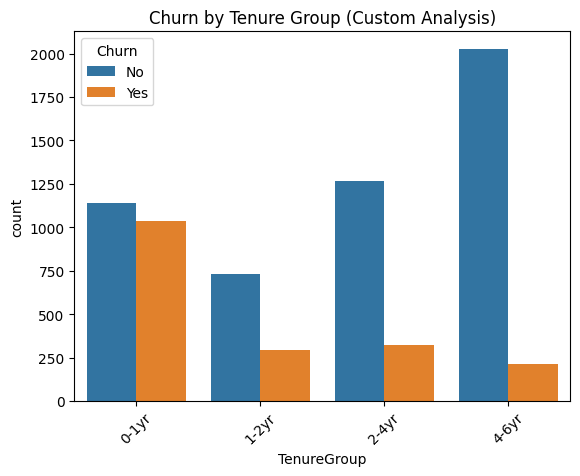

<Figure size 1000x600 with 0 Axes>

In [56]:
#Plot churn by tenure groups
import seaborn as sns
import matplotlib.pyplot as plt
raw_df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')  # Reload raw
raw_df['TenureGroup'] = pd.cut(raw_df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr'])
sns.countplot(x='TenureGroup', hue='Churn', data=raw_df)
plt.title('Churn by Tenure Group (Custom Analysis)')
plt.xticks(rotation=45)
plt.figure(figsize=(10, 6))
plt.savefig('churn_payment.png')
plt.show()
#Visualized tenure groups to highlight early churn risk

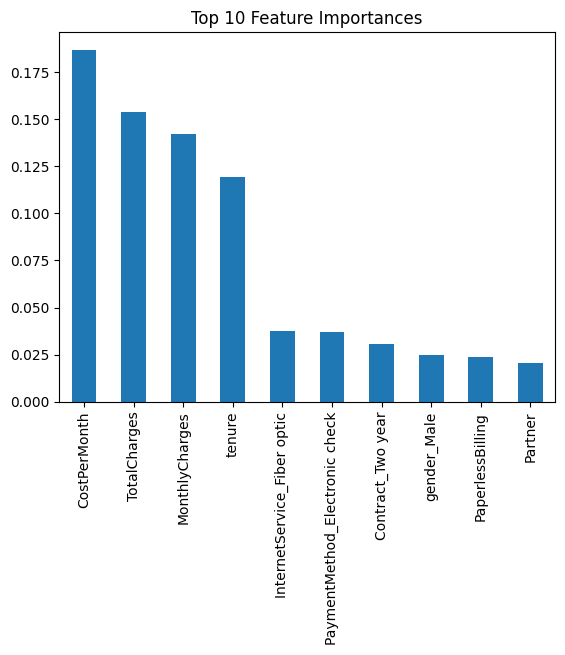

<Figure size 1000x600 with 0 Axes>

In [57]:
#Plot top 10 feature importances (Random Forest)
importances = model_rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:10]
feat_imp.plot(kind='bar')
plt.title('Top 10 Feature Importances')
plt.figure(figsize=(10, 6))
plt.savefig('feature_importance.png')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')